In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags_array, csc_array, eye_array
import scipy.sparse.linalg as sla
import pymrm as mrm
from pymrm import construct_grad, construct_div, newton

In [2]:
class DiffusionReaction:
    def __init__(self):
        self.D = 1.0
        self.L = 1.0
        self.N = 10
        self.bc = {'a':[0,1],'b':[1,0], 'd':[1,0]}
        self.k = 0.0
        self.dt = 0.01
        self.x_f = np.linspace(0,self.L,self.N+1)
        self.x_c = 0.5*(self.x_f[0:-1]+self.x_f[1:])
        self.init_field()
        self.init_Jac()
        self.freq_out = 10
    
    def init_field(self, c0=0.0):
        self.c = np.full((self.N,),c0, dtype='float')
    
    def init_Jac(self):
        Grad, grad_bc = construct_grad(self.c.shape, self.x_f, self.x_c, self.bc)
        Div = construct_div(self.c.shape, self.x_f)        
        Jac_diff = self.D * (Div @ Grad)
        f_diff_bc = self.D * (Div @ grad_bc)
        Jac_react = self.k*eye_array(self.N,format='csc')
        Jac_accum = (1.0/self.dt)*eye_array(self.N,format='csc')
        self.g_const = -f_diff_bc
        self.Jac_const = Jac_accum - Jac_diff + Jac_react
        
    def construct_Jac(self, c, c_old):
        g = self.g_const + self.Jac_const @ c.reshape((-1,1)) - c_old.reshape((-1,1))/self.dt
        Jac = self.Jac_const
        return g,Jac
        
    def solve(self, num_timesteps):
        Jac = self.Jac_const
        for i in range(num_timesteps):
            c_old = self.c.copy()
            result = newton(lambda c: self.construct_Jac(c, c_old), c_old, maxfev=10)
            self.c = result.x
            #g, Jac = self.construct_Jac(self.c, c_old)
            #dc = -sla.spsolve(Jac,g)
            #self.c[:] += dc
            if (i % self.freq_out == 0):
                plt.plot(self.x_c,self.c,'-o')
        plt.show()

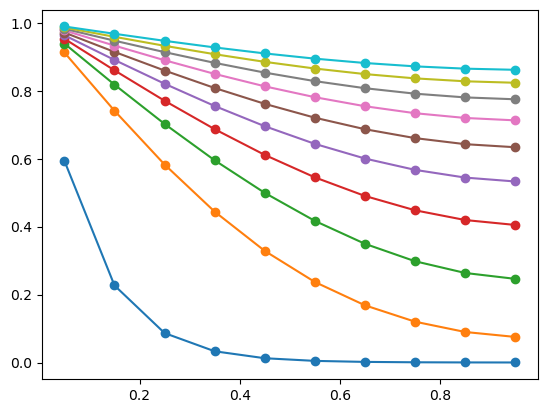

In [3]:
mrm_problem = DiffusionReaction()
mrm_problem.init_field()
mrm_problem.solve(100)